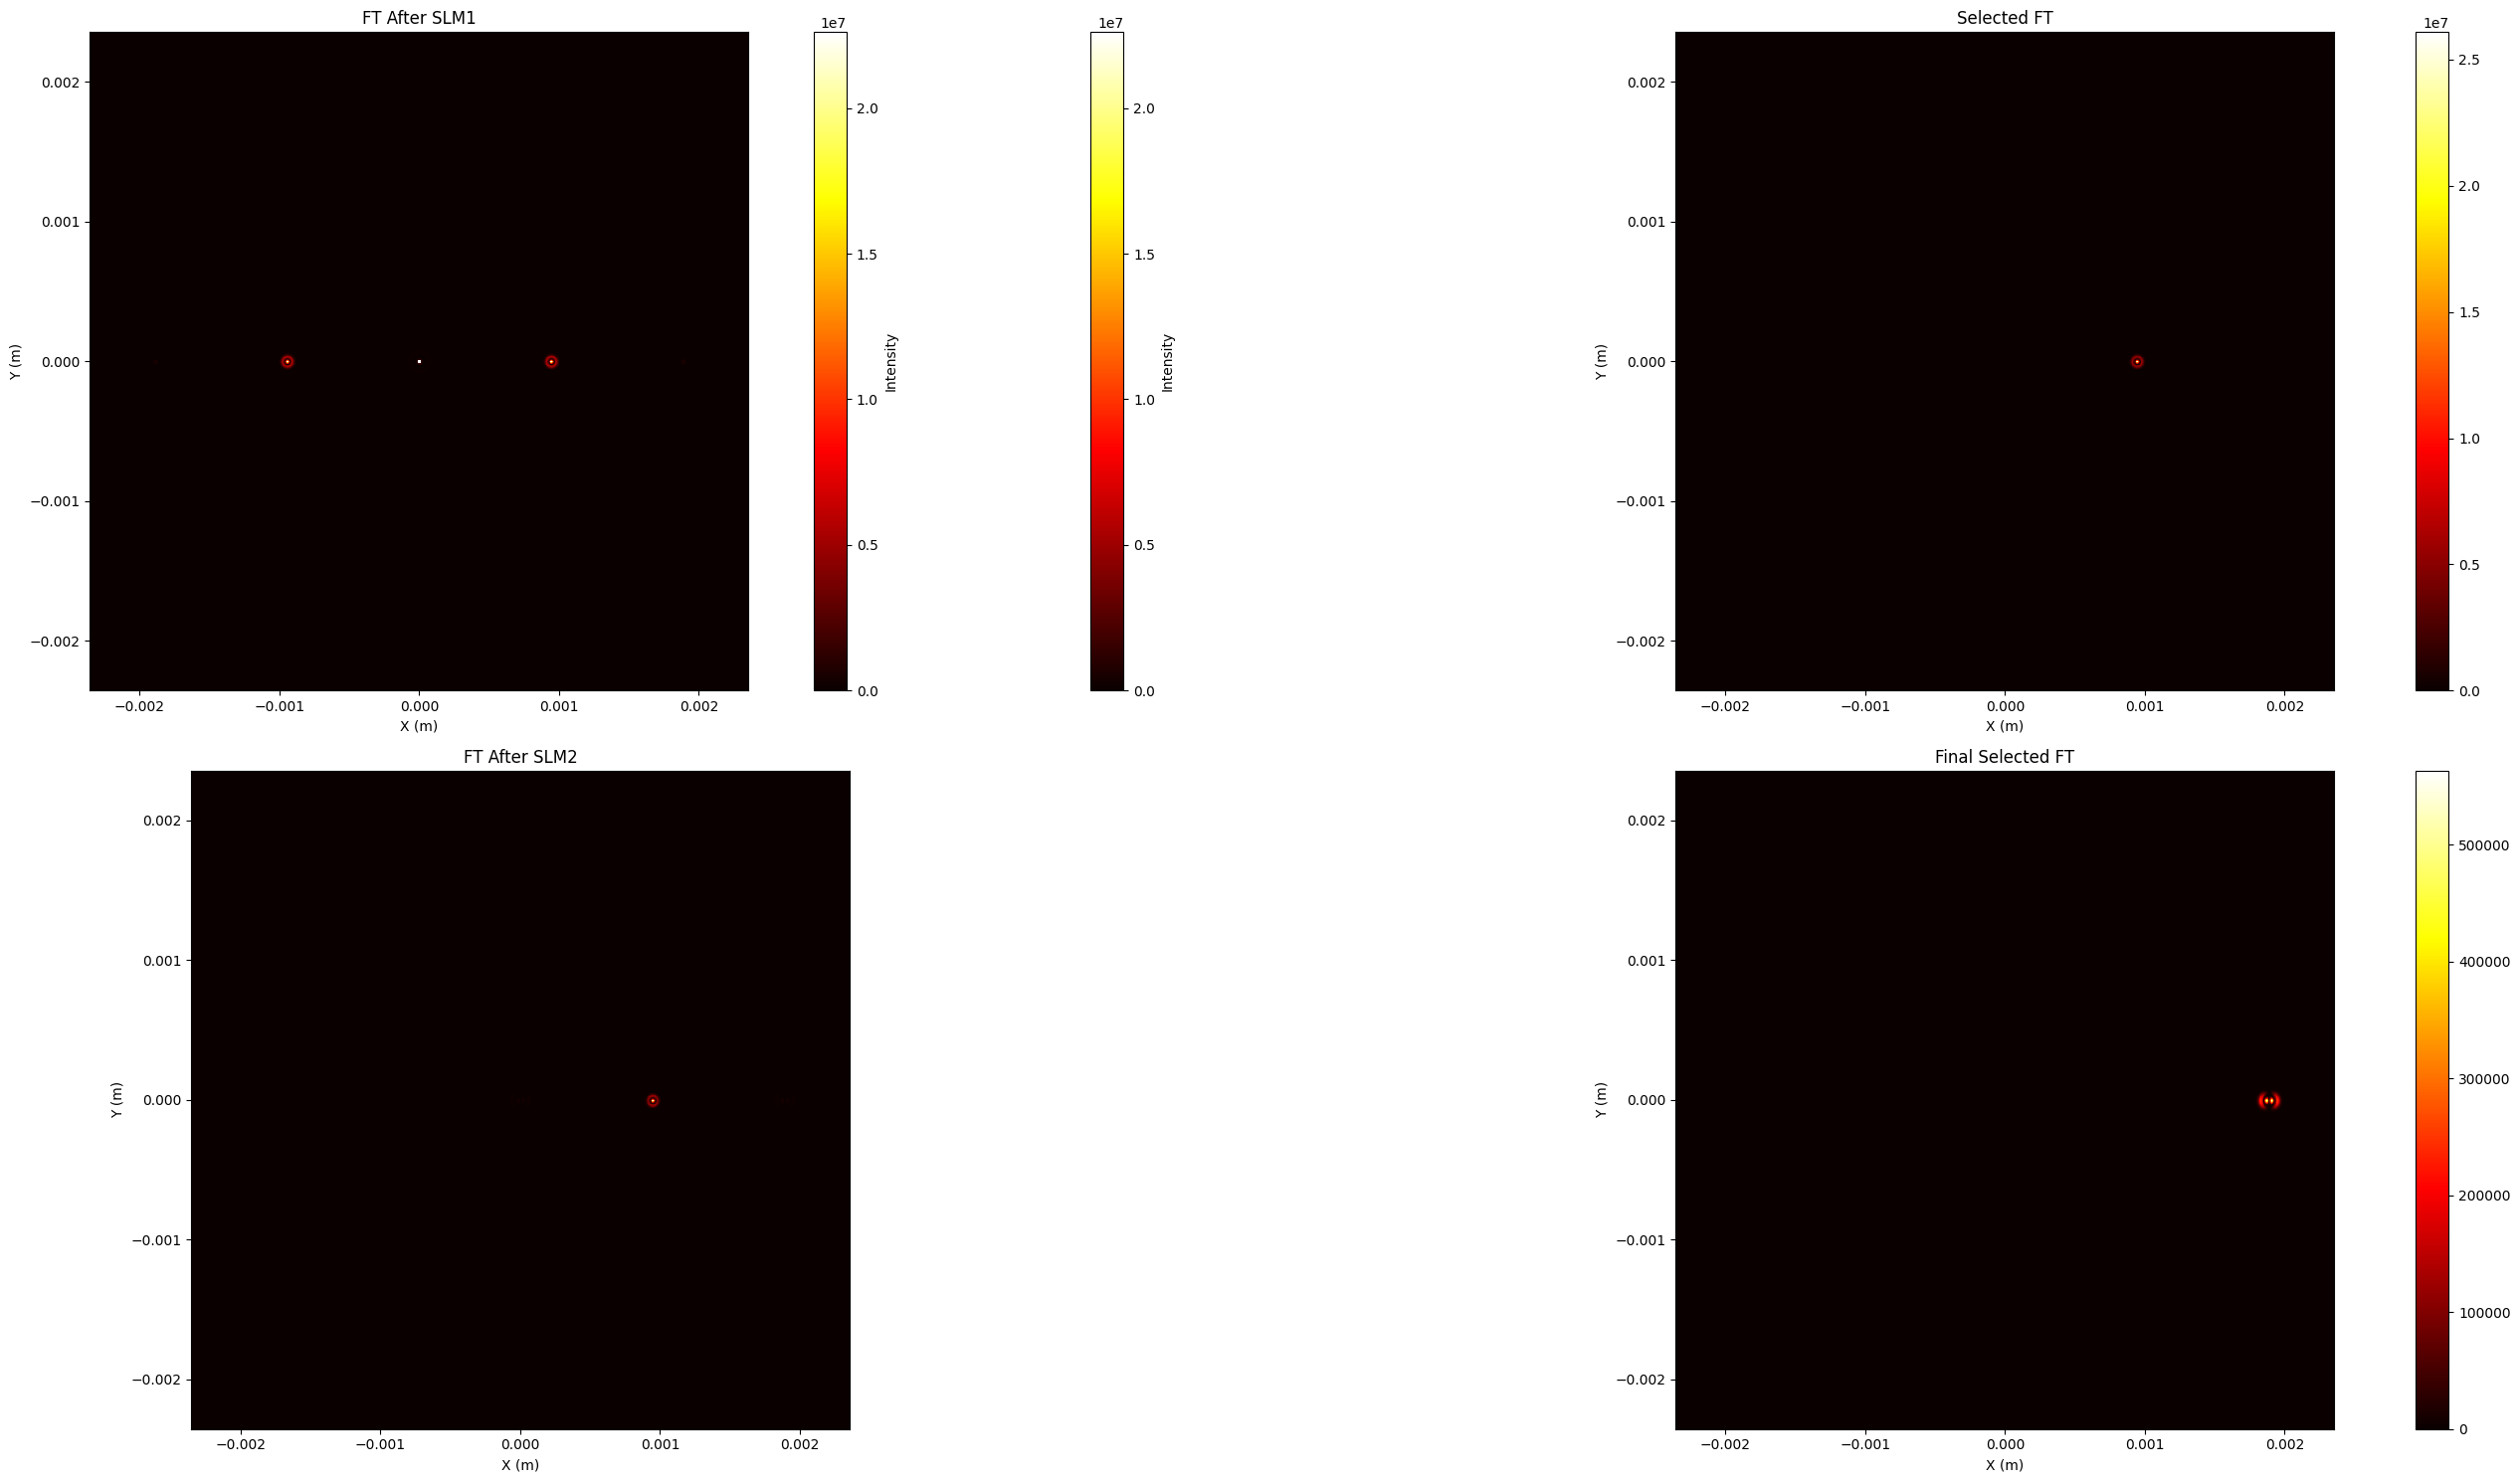

In [2]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import genlaguerre, hermite, j1
from scipy.optimize import newton
from scipy.fftpack import fftshift, fft2, ifftshift, ifft2
from matplotlib.colors import Normalize
import math

# Define Laguerre-Gaussian mode
def LG_mode(p, l, X, Y, theta, wz, z):
    r = np.sqrt(X**2 + Y**2)
    theta = np.arctan2(Y, X)
    if z == 0:
        Rz = np.inf
    else:
        Rz = (z**2 + zr**2) / z
    k0 = 2 * np.pi / lamda
    phase = np.exp(-1j * l * theta) * np.exp(1j * (k0 * r**2 / (2 * Rz) - (2*p + np.abs(l) + 1) * np.arctan(z / zr)))
    am = (2 * math.factorial(p) / (np.pi * math.factorial(p + np.abs(l))))**0.5 * \
         (1 / wz) * (np.sqrt(2) * r / wz)**np.abs(l) * np.exp(-(r**2 / wz**2)) * \
         genlaguerre(p, np.abs(l))(2 * r**2 / wz**2)
    return phase * am

# Define Hermite-Gaussian mode
def HG_mode(nx, ny, X, Y, wx, wy):
    return hermite(nx)(np.sqrt(2) * X / wx) * hermite(ny)(np.sqrt(2) * Y / wy) * \
           np.exp(-(X**2 / wx**2 + Y**2 / wy**2))

# Define mode conjugate function
def mode_conjugate(mode_func, *args, **kwargs):
    return np.conj(mode_func(*args, **kwargs))

# Define faeq function
def faeq(f_a_ref, a_ref):
    global C
    return j1(f_a_ref) - C * a_ref

# Find f_a_ref
def find_f_a_ref(a_ref):
    return newton(faeq, np.ones_like(a_ref) * 1, args=(a_ref,))

# Define SLM transmission
def slm_transmission(phi, fa):
    return np.exp(1j * (fa * np.sin(phi)))

# 4f system Fourier transform
def fourier_transform(field):
    return fftshift(fft2(ifftshift(field)))

def inverse_fourier_transform(field):
    return fftshift(ifft2(ifftshift(field)))

# Parameters
lamda = 0.66e-6
w0 = 500e-6
pix_size = 9.2e-6
size = 512
C = 0.5818
x = np.linspace(-size * pix_size / 2, size * pix_size / 2, size)
y = np.linspace(-size * pix_size / 2, size * pix_size / 2, size)
X, Y = np.meshgrid(x, y)
z = 0
zr = np.pi * w0**2 / lamda
wz = w0 * np.sqrt(1 + (z / zr)**2)

# Introduce phase shift factor
a = 5
grating_period = pix_size * a
phase_shift = np.exp(1j * (2 * np.pi * X / grating_period))

# Generate LG and HG fields and apply phase shift
LG01_field = LG_mode(1, 0, X, Y, np.arctan2(Y, X), wz, z) * phase_shift
AM01 = np.abs(LG01_field) / np.max(np.abs(LG01_field))
fa01 = find_f_a_ref(AM01)
phi01 = np.angle(LG01_field)

HG10_field = HG_mode(1, 0, X, Y, wz, wz) * phase_shift
AM10 = np.abs(HG10_field) / np.max(np.abs(HG10_field))
fa10 = find_f_a_ref(AM10)
phi10 = np.angle(HG10_field)

# Choose incident light type
incident_type = "plane"  # "plane" or "LG"

if incident_type == "plane":
    # Generate plane wave incident field
    incident_field = np.ones((size, size))
elif incident_type == "LG":
    # Generate Laguerre-Gaussian incident field
    incident_field = LG_mode(1, 0, X, Y, np.arctan2(Y, X), wz, z)

# After SLM1
field_after_slm1 = incident_field * slm_transmission(np.angle(LG01_field), fa01)
intensity_after_slm1 = np.abs(field_after_slm1)**2

# Fourier transform after SLM1
field_after_slm1_ft = fourier_transform(field_after_slm1)
intensity_after_slm1_ft = np.abs(field_after_slm1_ft)**2

# Pupil function, selecting ±1 order light
def create_circular_mask(h, w, center=None, radius=None):
    if center is None:
        center = (int(w/2), int(h/2))
    if radius is None:
        radius = min(center[0], center[1], w-center[0], h-center[1])
    
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)

    mask = dist_from_center <= radius
    return mask

radius = 50
mask1 = create_circular_mask(size, size, center=(size//2 + 125, size//2), radius=radius)
mask2 = create_circular_mask(size, size, center=(size//2 + 225, size//2), radius=radius)

selected_ft = field_after_slm1_ft * mask1

# Inverse Fourier transform
field_after_ifft = inverse_fourier_transform(selected_ft)
intensity_after_ifft = np.abs(field_after_ifft)**2

# After SLM2 transmission
field_after_slm2 = field_after_ifft * slm_transmission(np.angle(HG10_field), fa10)
intensity_after_slm2 = np.abs(field_after_slm2)**2

# Fourier transform after SLM2
field_after_slm2_ft = fourier_transform(field_after_slm2)
intensity_after_slm2_ft = np.abs(field_after_slm2_ft)**2

# Apply pupil function again
final_selected_ft = field_after_slm2_ft * mask2
intensity_final_selected_ft = np.abs(final_selected_ft)**2

# Display intensity distributions
plt.figure(figsize=(30, 15))

plt.subplot(2, 2, 1)
plt.title('FT After SLM1')
img = plt.imshow(intensity_after_slm1_ft, cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()], norm=Normalize(vmin=0, vmax=np.max(intensity_after_slm1_ft) / 3000))
cbar = plt.colorbar(img)
cbar.set_label('Intensity')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

plt.subplot(2, 2, 2)
plt.title('Selected FT')
plt.imshow(np.abs(selected_ft)**2, cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()])
plt.colorbar()
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

plt.subplot(2, 2, 3)
plt.title('FT After SLM2')
plt.imshow(intensity_after_slm2_ft, cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()])
cbar = plt.colorbar(img)
cbar.set_label('Intensity')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

plt.subplot(2, 2, 4)
plt.title('Final Selected FT')
plt.imshow(intensity_final_selected_ft, cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()])
plt.colorbar()
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

plt.tight_layout()
plt.show()


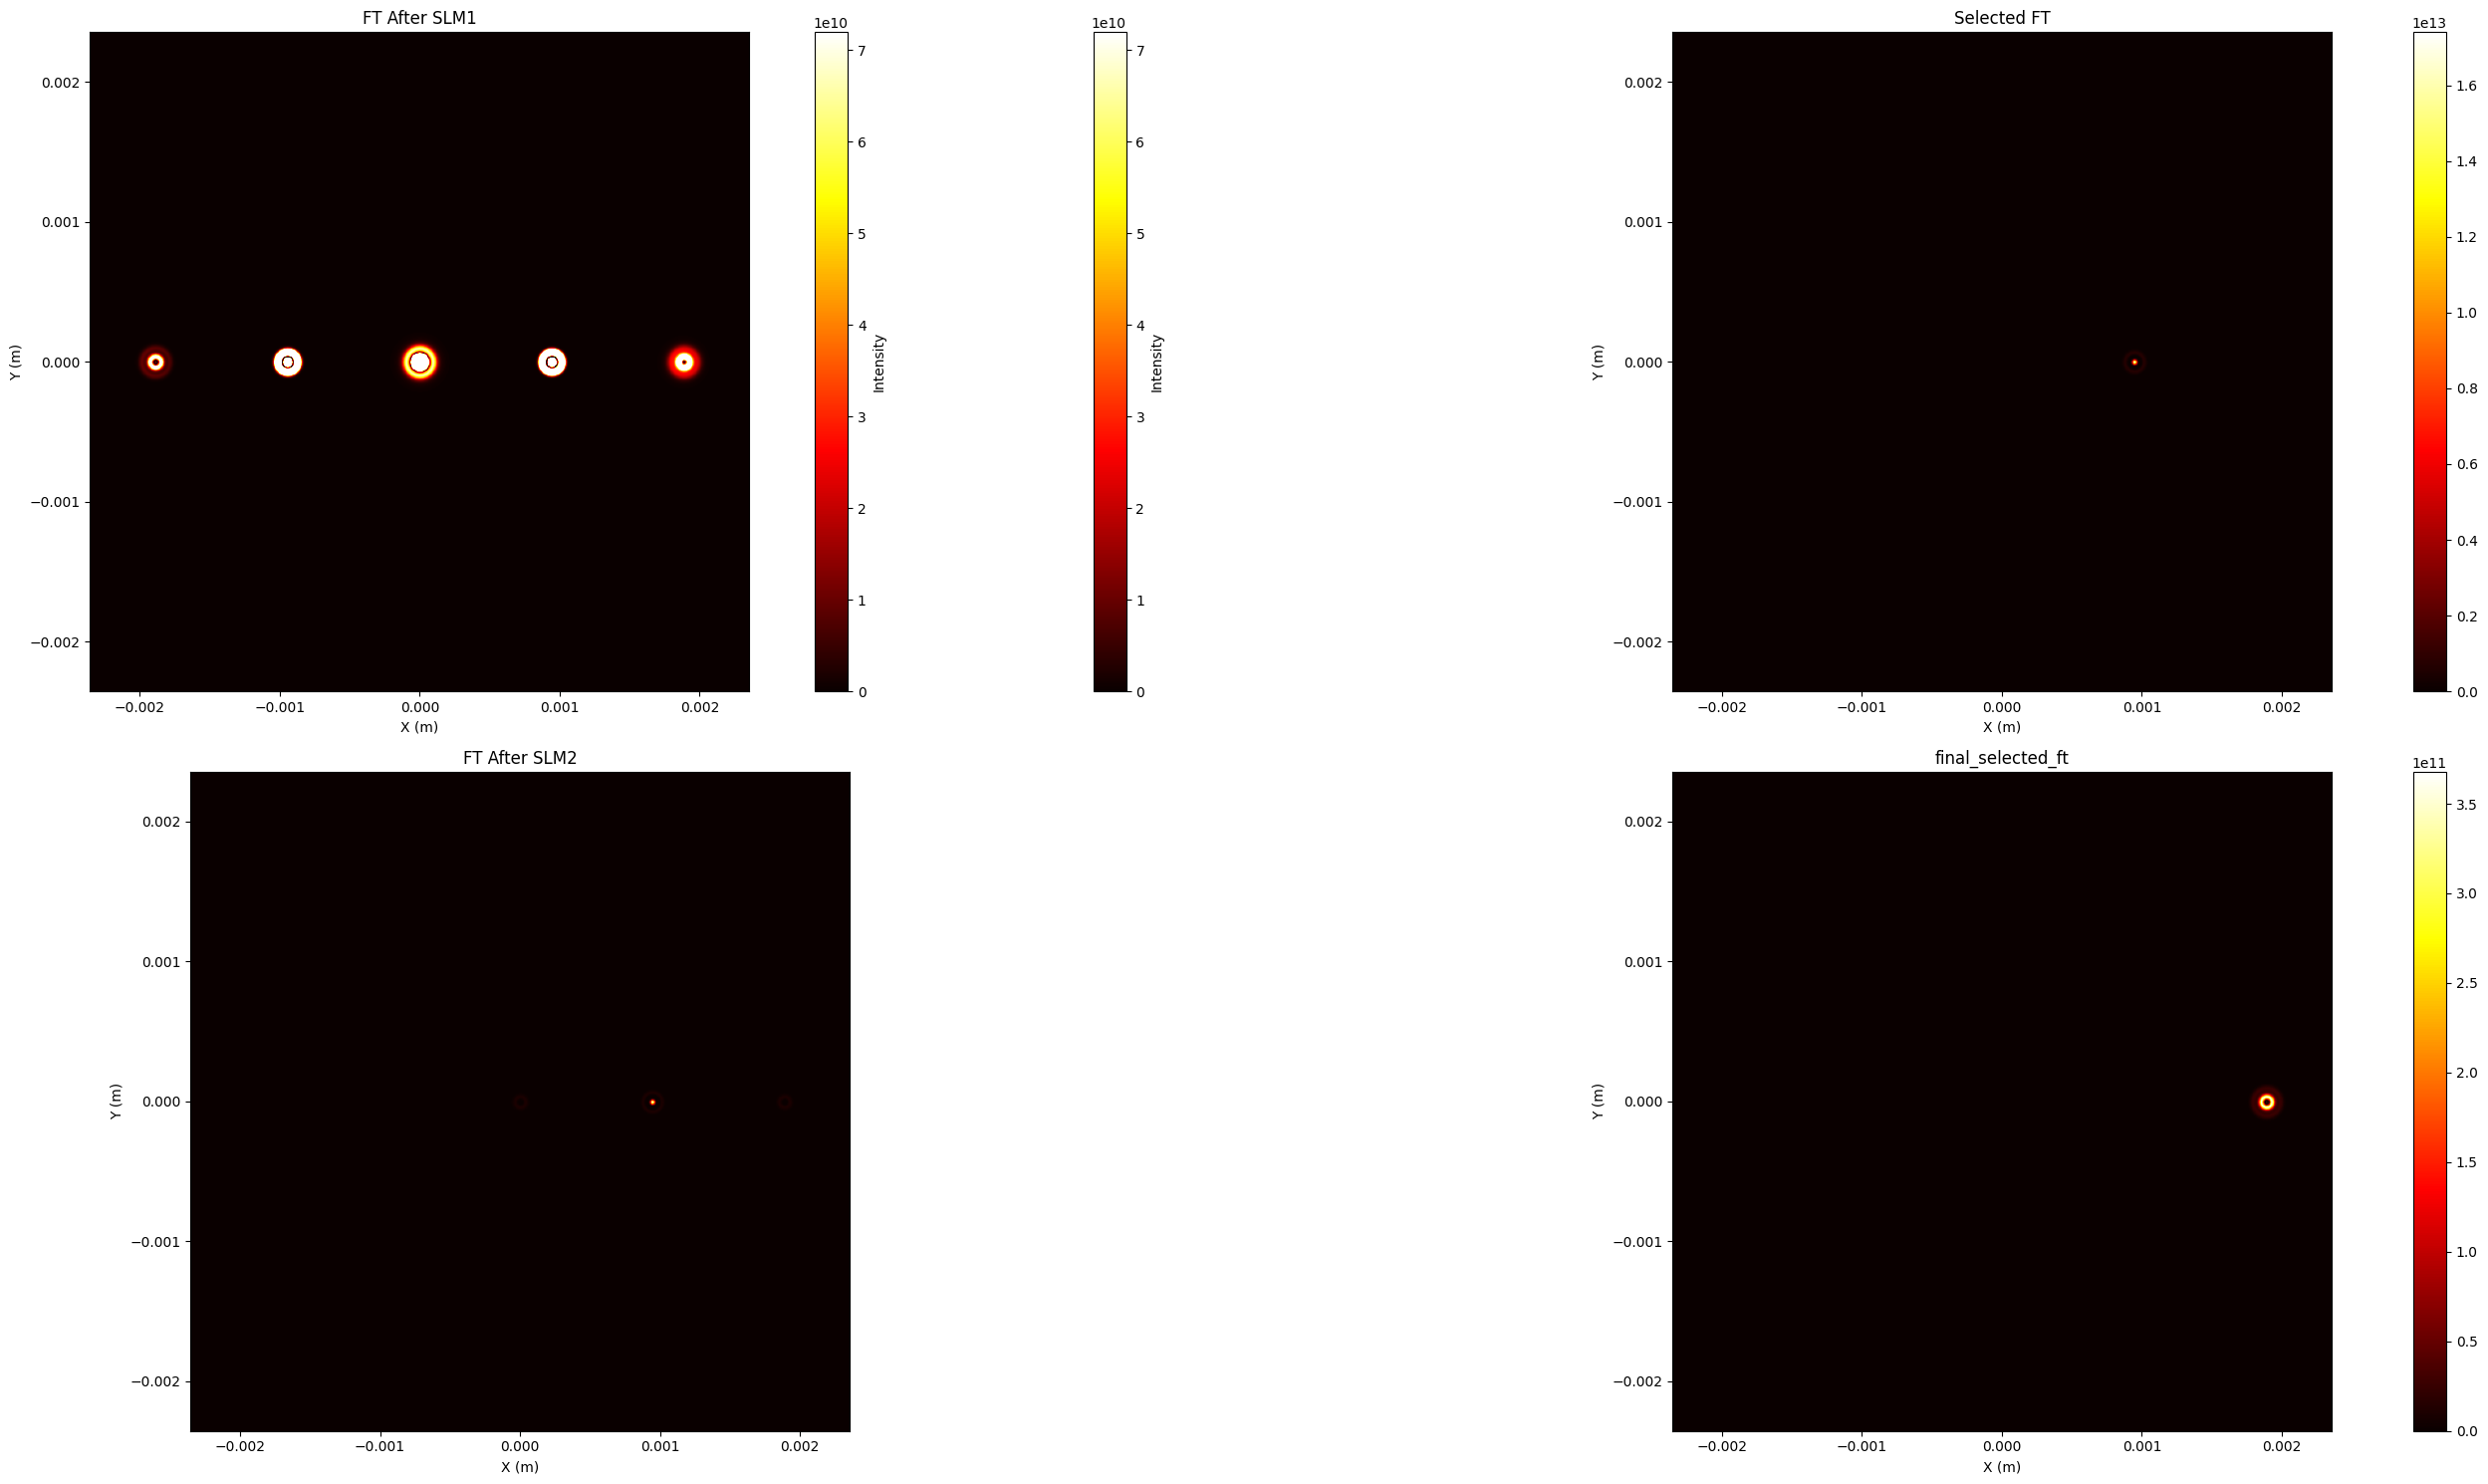

In [46]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import genlaguerre, j1
from scipy.optimize import newton
from scipy.fftpack import fftshift, fft2, ifftshift, ifft2
from matplotlib.colors import Normalize
from scipy.interpolate import RegularGridInterpolator
import math

# 定义 Laguerre-Gaussian 模式
def LG_mode(p, l, X, Y, theta, wz, z):
    r = np.sqrt(X**2 + Y**2)
    theta = np.arctan2(Y, X)
    if z == 0:
        Rz = np.inf
    else:
        Rz = (z**2 + zr**2) / z
    k0 = 2 * np.pi / lamda
    phase = np.exp(-1j * l * theta) * np.exp(1j * (k0 * r**2 / (2 * Rz) - (2*p + np.abs(l) + 1) * np.arctan(z / zr)))
    am = (2 * math.factorial(p) / (np.pi * math.factorial(p + np.abs(l))))**0.5 * \
         (1 / wz) * (np.sqrt(2) * r / wz)**np.abs(l) * np.exp(-(r**2 / wz**2)) * \
         genlaguerre(p, np.abs(l))(2 * r**2 / wz**2)
    return phase * am

def LG_mode_conjugate(p, l, X, Y, theta, wz, z):
    return np.conj(LG_mode(p, l, X, Y, theta, wz, z))

# 定义 faeq 函数
def faeq(f_a_ref, a_ref):
    global C
    return j1(f_a_ref) - C * a_ref

# 查找 f_a_ref
def find_f_a_ref(a_ref):
    return newton(faeq, np.ones_like(a_ref) * 1, args=(a_ref,))

# 定义 SLM 的透射率
def slm_transmission(phi, fa):
    return np.exp(1j * (fa * np.sin(phi)))

# 4f 系统的傅里叶变换
def fourier_transform(field):
    return fftshift(fft2(ifftshift(field)))

def inverse_fourier_transform(field):
    return fftshift(ifft2(ifftshift(field)))

# 定义球面波
def spherical_wave(X, Y, z, lamda):
    k = 2 * np.pi / lamda
    R = np.sqrt(X**2 + Y**2 + z**2)
    return np.exp(1j * k * R) / R
    
# 参数设置
lamda = 0.66e-6
w0 = 500e-6
pix_size = 9.2e-6
size = 512
C = 0.5818
x = np.linspace(-size * pix_size / 2, size * pix_size / 2, size)
y = np.linspace(-size * pix_size / 2, size * pix_size / 2, size)
X, Y = np.meshgrid(x, y)
z = 0
zr = np.pi * w0**2 / lamda
wz = w0 * np.sqrt(1 + (z / zr)**2)

# 引入平移相位因子
a = 5
grating_period = pix_size * a
phase_shift = np.exp(1j * (2 * np.pi * X / grating_period))

# 生成 LG 光场并引入平移
LG01_field = LG_mode(1, 0, X, Y, np.arctan2(Y, X), wz, z) * phase_shift
AM01 = np.abs(LG01_field) / np.max(np.abs(LG01_field))
fa01 = find_f_a_ref(AM01)
phi01 = np.angle(LG01_field)
LG10_field = LG_mode_conjugate(1, 0, X, Y, np.arctan2(Y, X), wz, z) * phase_shift
AM10 = np.abs(LG10_field) / np.max(np.abs(LG10_field))
fa10 = find_f_a_ref(AM10)
phi10 = np.angle(LG10_field)
spherical_mode= spherical_wave(X, Y, z, lamda)
# 用户选择入射光类型
incident_type = "plane"  # "plane" 或 "LG"

if incident_type == "plane":
    # 生成入射平面波光场
    incident_field = np.ones((size, size))
elif incident_type == "LG":
    # 生成入射 Laguerre-Gaussian 光场
    incident_field = LG_mode(1, 0, X, Y, np.arctan2(Y, X), wz, z)

# 经过 SLM1 后的光场
field_after_slm1 = incident_field * slm_transmission(np.angle(LG01_field), fa01)
intensity_after_slm1 = np.abs(field_after_slm1)**2

# 经过 SLM1 后傅里叶变换的光场
field_after_slm1_ft = fourier_transform(field_after_slm1)
intensity_after_slm1_ft = np.abs(field_after_slm1_ft)**2

# 瞳函数，选择±1级的光
def create_circular_mask(h, w, center=None, radius=None):
    if center is None:
        center = (int(w/2), int(h/2))
    if radius is None:
        radius = min(center[0], center[1], w-center[0], h-center[1])
    
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)

    mask = dist_from_center <= radius
    return mask

radius = 50
mask1 = create_circular_mask(size, size, center=(size//2 + 125, size//2), radius=radius)
mask2 = create_circular_mask(size, size, center=(size//2 + 225, size//2), radius=radius)
mask3 = create_circular_mask(size, size, center=(size//2 , size//2+ 125), radius=radius)
mask4 = create_circular_mask(size, size, center=(size//2 , size//2+ 225), radius=radius)
mask5 = create_circular_mask(size, size, center=(size//2 + 125, size//2+ 125), radius=radius)
mask6 = create_circular_mask(size, size, center=(size//2 + 225, size//2+ 225), radius=radius)

selected_ft = field_after_slm1_ft * mask1

# 反傅里叶变换
field_after_ifft = inverse_fourier_transform(selected_ft)
intensity_after_ifft = np.abs(field_after_ifft)**2

# 经过 SLM2 的透射率
field_after_slm2 = field_after_ifft * slm_transmission(np.angle(LG10_field), fa10)
intensity_after_slm2 = np.abs(field_after_slm2)**2

# 经过 SLM2 后傅里叶变换的光场
field_after_slm2_ft = fourier_transform(field_after_slm2)
intensity_after_slm2_ft = np.abs(field_after_slm2_ft)**2

# 再次应用瞳函数
final_selected_ft = field_after_slm2_ft * mask2
intensity_final_selected_ft = np.abs(final_selected_ft)**2

# 显示光强分布
plt.figure(figsize=(30, 15))

plt.subplot(2, 2, 1)
plt.title('FT After SLM1')
img = plt.imshow(intensity_after_slm1_ft, cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()], norm=Normalize(vmin=0, vmax=np.max(intensity_after_slm1_ft) / 3000))
cbar = plt.colorbar(img)
cbar.set_label('Intensity')  # 添加标签
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

plt.subplot(2, 2, 2)
plt.title('Selected FT')
plt.imshow(np.abs(selected_ft)**2, cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()])
plt.colorbar()
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

plt.subplot(2, 2, 3)
plt.title('FT After SLM2')
plt.imshow(intensity_after_slm2_ft, cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()])
cbar = plt.colorbar(img)
cbar.set_label('Intensity')  # 添加标签
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

plt.subplot(2, 2, 4)
plt.title('final_selected_ft')
plt.imshow(intensity_final_selected_ft, cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()])
plt.colorbar()
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

plt.tight_layout()
plt.show()


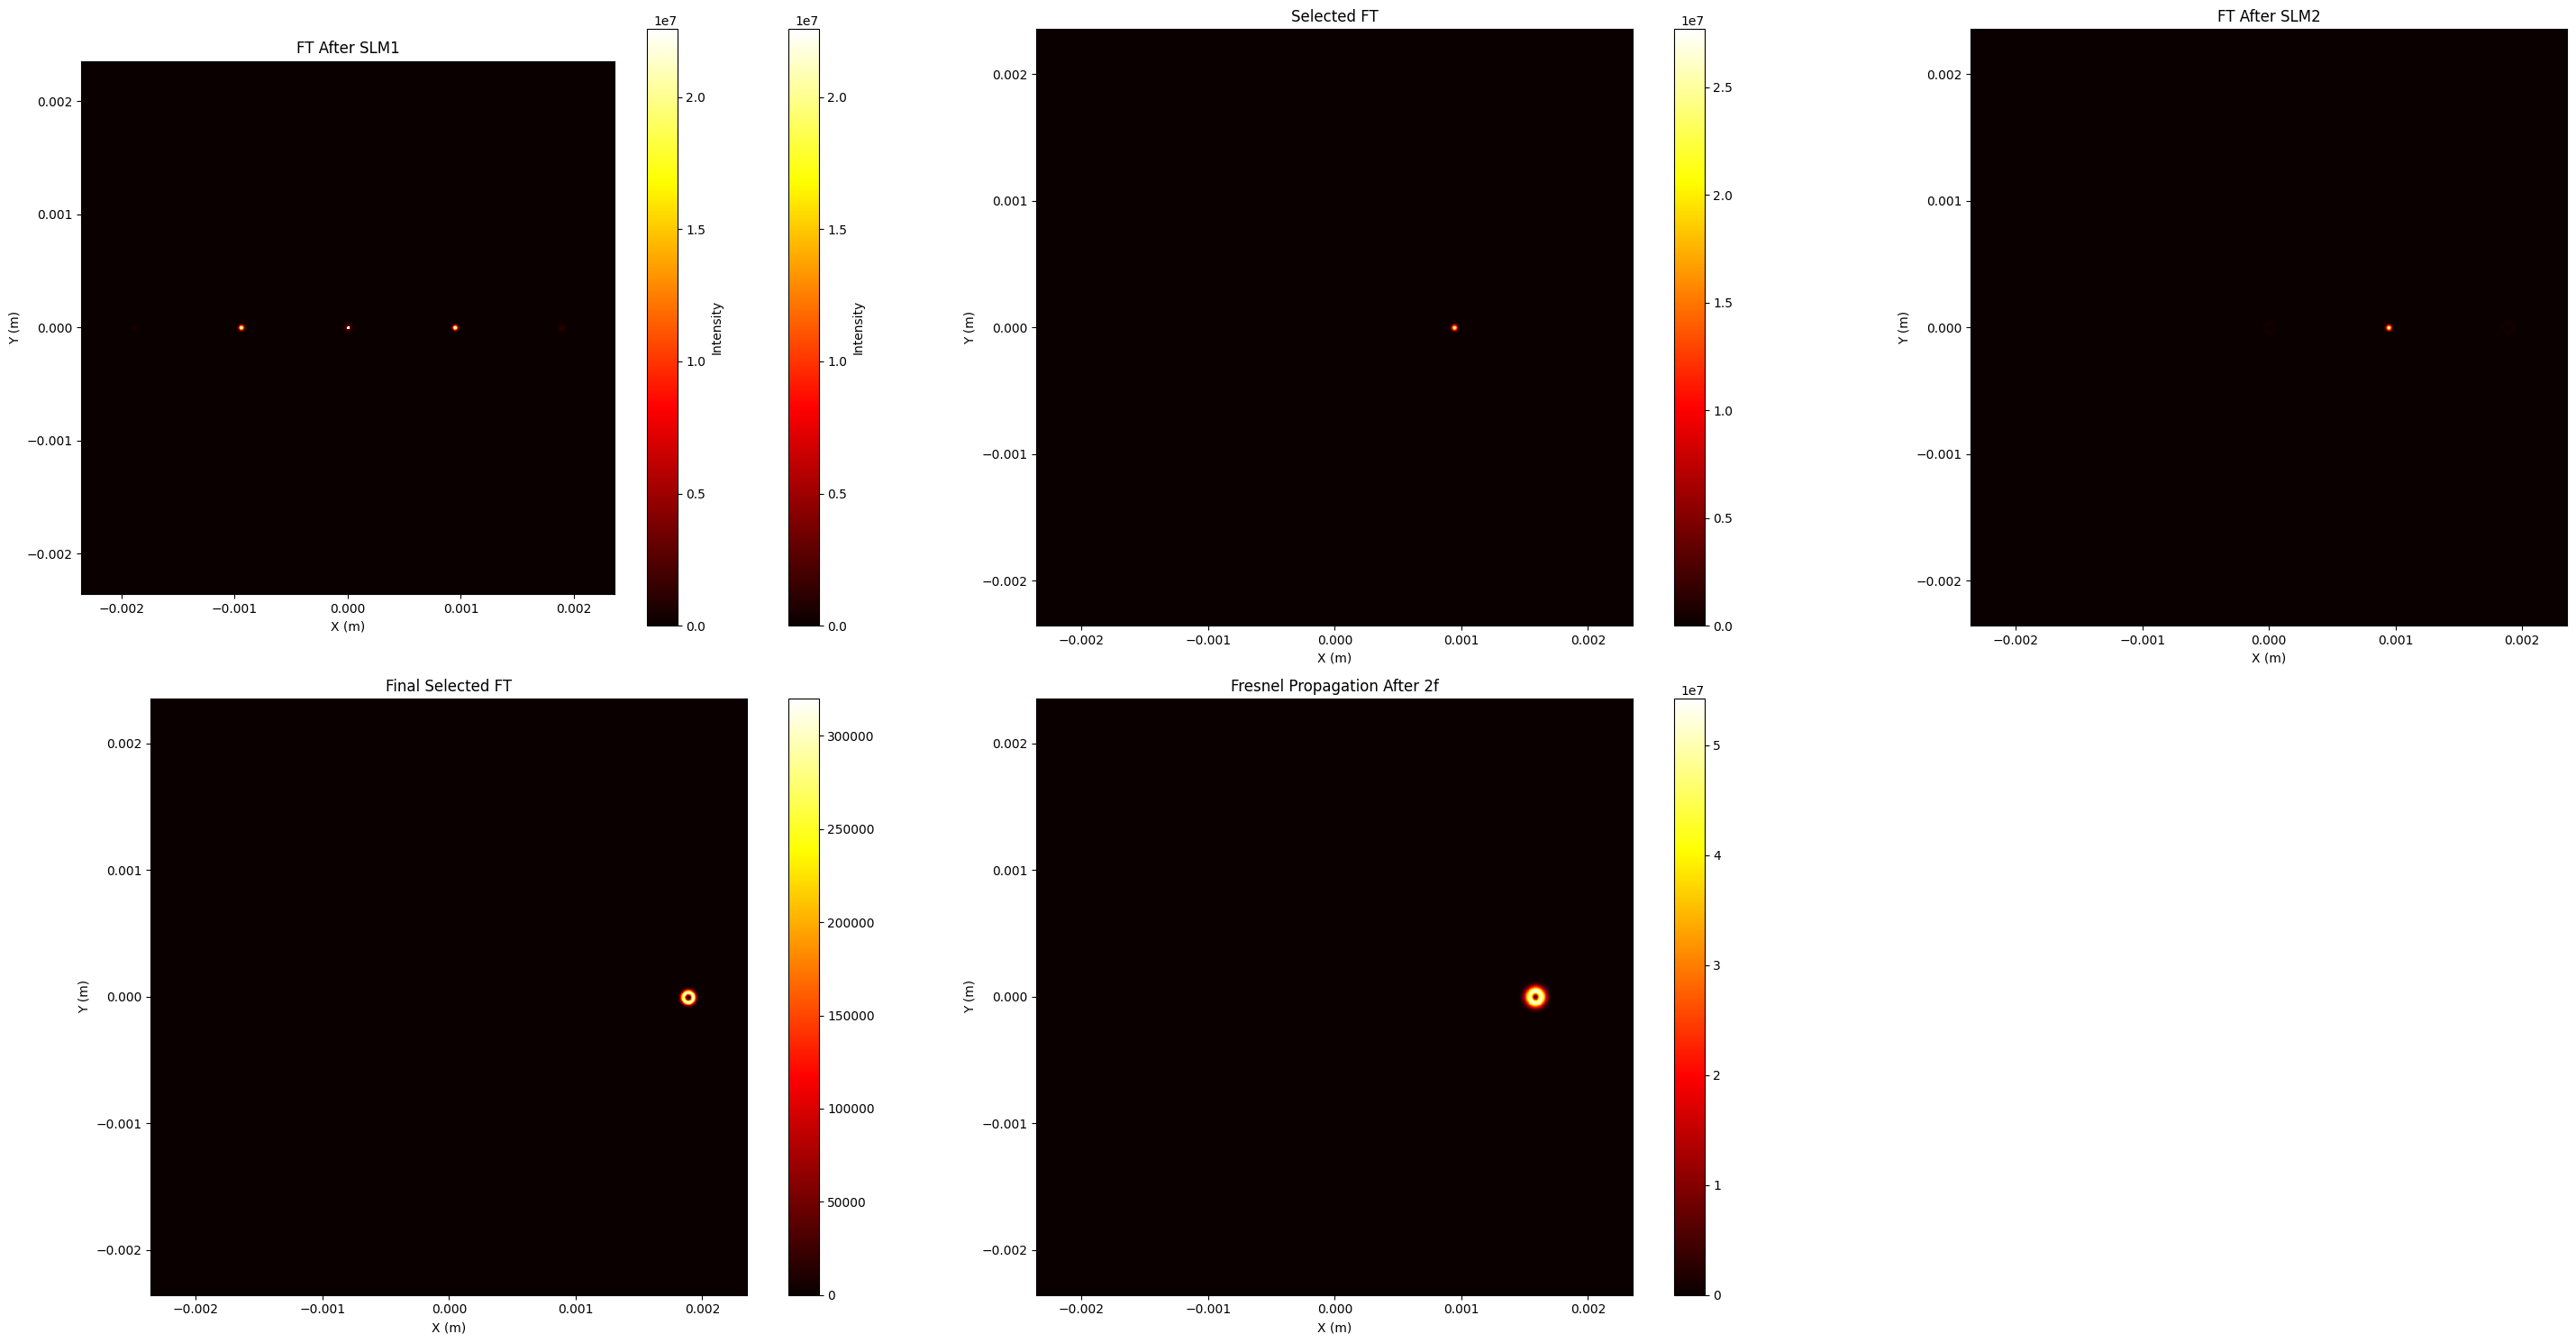

In [45]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import genlaguerre, j1
from scipy.optimize import newton
from scipy.fftpack import fftshift, fft2, ifftshift, ifft2
from matplotlib.colors import Normalize
import math

# 定义 Laguerre-Gaussian 模式
def LG_mode(p, l, X, Y, theta, wz, z):
    r = np.sqrt(X**2 + Y**2)
    theta = np.arctan2(Y, X)
    if z == 0:
        Rz = np.inf
    else:
        Rz = (z**2 + zr**2) / z
    k0 = 2 * np.pi / lamda
    phase = np.exp(-1j * l * theta) * np.exp(1j * (k0 * r**2 / (2 * Rz) - (2*p + np.abs(l) + 1) * np.arctan(z / zr)))
    am = (2 * math.factorial(p) / (np.pi * math.factorial(p + np.abs(l))))**0.5 * \
         (1 / wz) * (np.sqrt(2) * r / wz)**np.abs(l) * np.exp(-(r**2 / wz**2)) * \
         genlaguerre(p, np.abs(l))(2 * r**2 / wz**2)
    return phase * am

def LG_mode_conjugate(p, l, X, Y, theta, wz, z):
    return np.conj(LG_mode(p, l, X, Y, theta, wz, z))

# 定义 faeq 函数
def faeq(f_a_ref, a_ref):
    global C
    return j1(f_a_ref) - C * a_ref

# 查找 f_a_ref
def find_f_a_ref(a_ref):
    return newton(faeq, np.ones_like(a_ref) * 1, args=(a_ref,))

# 定义 SLM 的透射率
def slm_transmission(phi, fa):
    return np.exp(1j * (fa * np.sin(phi)))

# 4f 系统的傅里叶变换
def fourier_transform(field):
    return fftshift(fft2(ifftshift(field)))

def inverse_fourier_transform(field):
    return fftshift(ifft2(ifftshift(field)))

# 定义球面波
def spherical_wave(X, Y, z, lamda):
    k = 2 * np.pi / lamda
    R = np.sqrt(X**2 + Y**2 + z**2)
    return np.exp(1j * k * R) / R
    
# 参数设置
lamda = 0.66e-6
w0 = 500e-6
pix_size = 9.2e-6
size = 512
C = 0.5818
x = np.linspace(-size * pix_size / 2, size * pix_size / 2, size)
y = np.linspace(-size * pix_size / 2, size * pix_size / 2, size)
X, Y = np.meshgrid(x, y)
z = 0
zr = np.pi * w0**2 / lamda
wz = w0 * np.sqrt(1 + (z / zr)**2)

# 引入平移相位因子
a = 5
grating_period = pix_size * a
phase_shift = np.exp(1j * (2 * np.pi * X / grating_period))

# 生成 LG 光场并引入平移
LG01_field = LG_mode(0, 0, X, Y, np.arctan2(Y, X), wz, z) * phase_shift
AM01 = np.abs(LG01_field) / np.max(np.abs(LG01_field))
fa01 = find_f_a_ref(AM01)
phi01 = np.angle(LG01_field)
LG10_field = LG_mode_conjugate(1, 0, X, Y, np.arctan2(Y, X), wz, z) * phase_shift
AM10 = np.abs(LG10_field) / np.max(np.abs(LG10_field))
fa10 = find_f_a_ref(AM10)
phi10 = np.angle(LG10_field)

# 用户选择入射光类型
incident_type = "plane"  # "plane" 或 "LG"

if incident_type == "plane":
    # 生成入射平面波光场
    incident_field = np.ones((size, size))
elif incident_type == "LG":
    # 生成入射 Laguerre-Gaussian 光场
    incident_field = LG_mode(1, 0, X, Y, np.arctan2(Y, X), wz, z)

# 经过 SLM1 后的光场
field_after_slm1 = incident_field * slm_transmission(np.angle(LG01_field), fa01)
intensity_after_slm1 = np.abs(field_after_slm1)**2

# 经过 SLM1 后傅里叶变换的光场
field_after_slm1_ft = fourier_transform(field_after_slm1)
intensity_after_slm1_ft = np.abs(field_after_slm1_ft)**2

# 瞳函数，选择±1级的光
def create_circular_mask(h, w, center=None, radius=None):
    if center is None:
        center = (int(w/2), int(h/2))
    if radius is None:
        radius = min(center[0], center[1], w-center[0], h-center[1])
    
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)

    mask = dist_from_center <= radius
    return mask

radius = 50
mask1 = create_circular_mask(size, size, center=(size//2 + 125, size//2), radius=radius)
mask2 = create_circular_mask(size, size, center=(size//2 + 225, size//2), radius=radius)

selected_ft = field_after_slm1_ft * mask1

# 反傅里叶变换
field_after_ifft = inverse_fourier_transform(selected_ft)
intensity_after_ifft = np.abs(field_after_ifft)**2

# 经过 SLM2 的透射率
field_after_slm2 = field_after_ifft * slm_transmission(np.angle(LG10_field), fa10)
intensity_after_slm2 = np.abs(field_after_slm2)**2

# 经过 SLM2 后傅里叶变换的光场
field_after_slm2_ft = fourier_transform(field_after_slm2)
intensity_after_slm2_ft = np.abs(field_after_slm2_ft)**2

# 再次应用瞳函数
final_selected_ft = field_after_slm2_ft * mask2
intensity_final_selected_ft = np.abs(final_selected_ft)**2
wavelength=lamda
f = 0.1
# 使用菲涅尔积分计算光场
def lens(x,y,f,lamda):
    return np.exp(-1j*np.pi*(x**2+y**2)/lamda/f)
l = lens(X,Y,1.1*f,wavelength)    
def transferfunction(x,y,dz,lamda):
    Ny,Nx = x.shape
    #k-space co-ordinate System
    f = Nx/(np.max(x)-np.min(x))
    v_x = f*(np.arange(-Nx/2,Nx/2)/Nx)
    fs = Nx/(np.max(y)-np.min(y))
    v_y = f*(np.arange(-Ny/2,Ny/2)/Ny)
    [xx,yy] = np.meshgrid(v_x,v_y)
    #Exponent for the transfer function of free-space
    H0 = np.exp(1j*2*np.pi*np.sqrt(lamda**(-2)-(xx)**2-(yy)**2)*dz)
    return H0    

def propagation(f,H0):
    F = fftshift(fft2(fftshift(f)))
    F = F*H0
    f = fftshift(ifft2(fftshift(F)))
    return f

# 定义系统参数
U=LG_mode(0, 1, X, Y, np.arctan2(Y, X), wz, z) * phase_shift
H0 = transferfunction(Y,X,f,wavelength)
H1 = transferfunction(Y,X,1.2*f,wavelength)
# 2f system
U = propagation(U,H0)
U = U*l
U = propagation(U,H1)
U[330:390,330:390]=0
# 显示光强分布
plt.figure(figsize=(30, 15))

plt.subplot(2, 3, 1)
plt.title('FT After SLM1')
img = plt.imshow(intensity_after_slm1_ft, cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()], norm=Normalize(vmin=0, vmax=np.max(intensity_after_slm1_ft) / 3000))
cbar = plt.colorbar(img)
cbar.set_label('Intensity')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

plt.subplot(2, 3, 2)
plt.title('Selected FT')
plt.imshow(np.abs(selected_ft)**2, cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()])
plt.colorbar()
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

plt.subplot(2, 3, 3)
plt.title('FT After SLM2')
plt.imshow(intensity_after_slm2_ft, cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()])
cbar = plt.colorbar(img)
cbar.set_label('Intensity')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

plt.subplot(2, 3, 4)
plt.title('Final Selected FT')
plt.imshow(intensity_final_selected_ft, cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()])
plt.colorbar()
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

plt.subplot(2, 3, 5)
plt.title('Fresnel Propagation After 2f')
plt.imshow(np.abs(U)**2, cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()])
plt.colorbar()
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

plt.tight_layout()
plt.show()


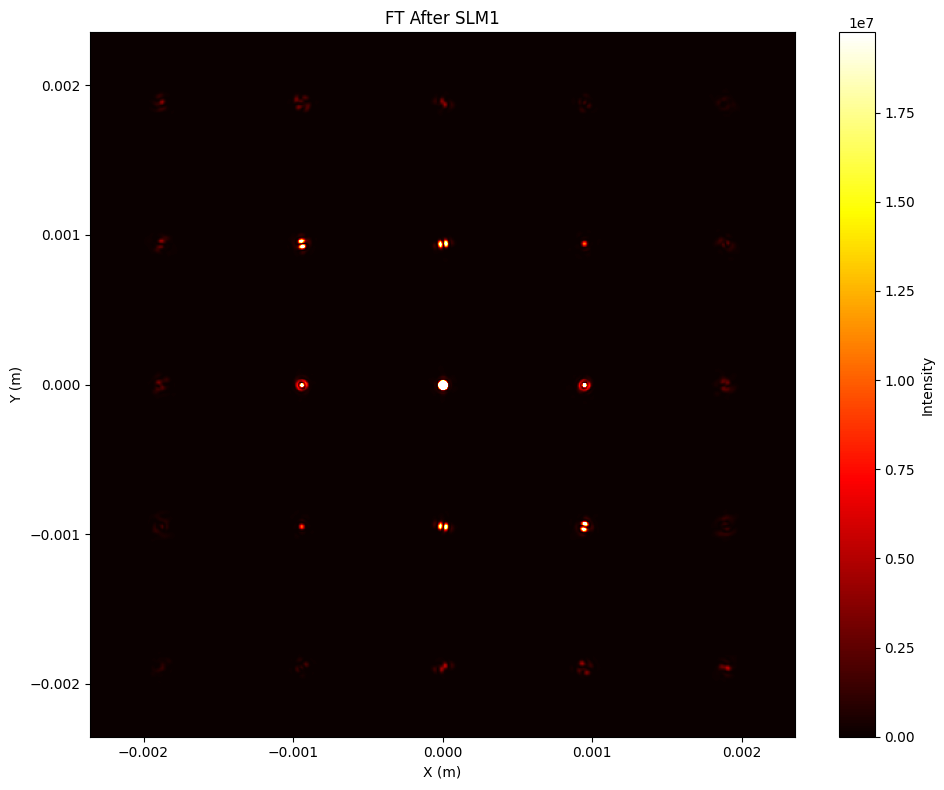

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import genlaguerre, j1, eval_hermite
from scipy.optimize import newton
from scipy.fftpack import fftshift, fft2, ifftshift, ifft2
from matplotlib.colors import Normalize
import math

# 定义 Laguerre-Gaussian 模式
def LG_mode(p, l, X, Y, theta, wz, z):
    r = np.sqrt(X**2 + Y**2)
    theta = np.arctan2(Y, X)
    if z == 0:
        Rz = np.inf
    else:
        Rz = (z**2 + zr**2) / z
    k0 = 2 * np.pi / lamda
    phase = np.exp(-1j * l * theta) * np.exp(1j * (k0 * r**2 / (2 * Rz) - (2*p + np.abs(l) + 1) * np.arctan(z / zr)))
    am = (2 * math.factorial(p) / (np.pi * math.factorial(p + np.abs(l))))**0.5 * \
         (1 / wz) * (np.sqrt(2) * r / wz)**np.abs(l) * np.exp(-(r**2 / wz**2)) * \
         genlaguerre(p, np.abs(l))(2 * r**2 / wz**2)
    return phase * am

def HG_mode(nx, ny, X, Y, wz):
    # 计算 Hermite 多项式
    Hx = eval_hermite(nx, np.sqrt(2) * X / wz)
    Hy = eval_hermite(ny, np.sqrt(2) * Y / wz)

    # 计算 Hermite-Gaussian 模式
    amplitude = (1 / np.sqrt(2**(nx+ny) * math.factorial(nx) * math.factorial(ny))) * \
                (1 / wz) * \
                np.exp(-(X**2 + Y**2) / wz**2) * \
                Hx * Hy
    
    # 计算相位
    phase = np.exp(-1j * (nx + ny + 1) * np.arctan(z / zr))

    return amplitude * phase
    
def LG_mode_conjugate(p, l, X, Y, theta, wz, z):
    return np.conj(LG_mode(p, l, X, Y, theta, wz, z))

# 定义 faeq 函数
def faeq(f_a_ref, a_ref):
    global C
    return j1(f_a_ref) - C * a_ref

# 查找 f_a_ref
def find_f_a_ref(a_ref):
    return newton(faeq, np.ones_like(a_ref) * 1, args=(a_ref,))

# 定义 SLM 的透射率
def slm_transmission(phi, fa):
    return np.exp(1j * (fa * np.sin(phi)))

# 4f 系统的傅里叶变换
def fourier_transform(field):
    return fftshift(fft2(ifftshift(field)))

def inverse_fourier_transform(field):
    return fftshift(ifft2(ifftshift(field)))

# 定义球面波
def spherical_wave(X, Y, z, lamda):
    k = 2 * np.pi / lamda
    R = np.sqrt(X**2 + Y**2 + z**2)
    return np.exp(1j * k * R) / R
    
# 参数设置
lamda = 0.66e-6
w0 = 500e-6
pix_size = 9.2e-6
size = 512
C = 0.5818
x = np.linspace(-size * pix_size / 2, size * pix_size / 2, size)
y = np.linspace(-size * pix_size / 2, size * pix_size / 2, size)
X, Y = np.meshgrid(x, y)
z = 0
zr = np.pi * w0**2 / lamda
wz = w0 * np.sqrt(1 + (z / zr)**2)

# 引入平移相位因子
a = 5
grating_period = pix_size * a
phase_shift1 = np.exp(1j * (2 * np.pi * X / grating_period))
phase_shift2 = np.exp(1j * (2 * np.pi * Y / grating_period))
phase_shift3 = np.exp(1j * (2 * np.pi * (X+Y) / grating_period))
phase_shift4 = np.exp(1j * (2 * np.pi * (X-Y) / grating_period))

# 生成 LG 光场并引入平移
LG01_field = LG_mode(1, 0, X, Y, np.arctan2(Y, X), wz, z) * phase_shift1
AMLG01 = np.abs(LG01_field) / np.max(np.abs(LG01_field))
faLG01 = find_f_a_ref(AMLG01)
phiLG01 = np.angle(LG01_field)

HG10_field = HG_mode(1, 0,  X, Y, wz) * phase_shift2
AMHG10 = np.abs(HG10_field) / np.max(np.abs(HG10_field))
faHG10 = find_f_a_ref(AMHG10)
phiHG10 = np.angle(HG10_field)

HG01_field = HG_mode(0, 1,  X, Y, wz) * phase_shift3
AMHG01 = np.abs(HG01_field) / np.max(np.abs(HG01_field))
faHG01 = find_f_a_ref(AMHG01)
phiHG01 = np.angle(HG01_field)

LG00_field = LG_mode_conjugate(0, 0, X, Y, np.arctan2(Y, X), wz, z) * phase_shift4
AMLG00 = np.abs(LG00_field) / np.max(np.abs(LG00_field))
faLG00 = find_f_a_ref(AMLG00)
phi00 = np.angle(LG00_field)

field = LG01_field + HG10_field + HG01_field + LG00_field
fa = faLG00 + faHG01 + faHG10 + faLG01

# 用户选择入射光类型
incident_type = "plane"  # "plane" 或 "LG"

if incident_type == "plane":
    # 生成入射平面波光场
    incident_field = np.ones((size, size))
elif incident_type == "LG":
    # 生成入射 Laguerre-Gaussian 光场
    incident_field = LG_mode(0, 0, X, Y, np.arctan2(Y, X), wz, z)

# 经过 SLM1 后的光场
field_after_slm1 = incident_field * slm_transmission(np.angle(field), fa)
intensity_after_slm1 = np.abs(field_after_slm1)**2

# 经过 SLM1 后傅里叶变换的光场
field_after_slm1_ft = fourier_transform(field_after_slm1)
intensity_after_slm1_ft = np.abs(field_after_slm1_ft)**2
intensity_after_slm1_ft[-100:100,-100:100] = 0

# 显示光强分布
plt.figure(figsize=(10, 8))
plt.title('FT After SLM1')
img = plt.imshow(intensity_after_slm1_ft, cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()], norm=Normalize(vmin=0, vmax=np.max(intensity_after_slm1_ft) / 3000))
cbar = plt.colorbar(img)
cbar.set_label('Intensity')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.tight_layout()
plt.show()


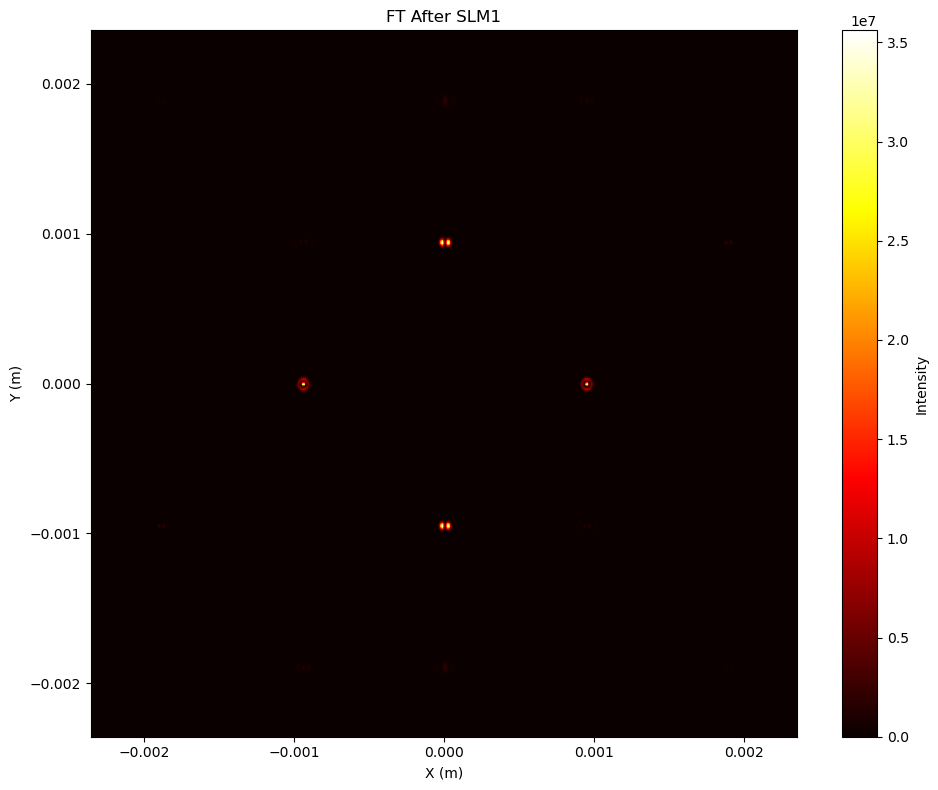

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import genlaguerre, eval_hermite
from scipy.optimize import newton
from scipy.fftpack import fftshift, fft2, ifftshift, ifft2
from matplotlib.colors import Normalize
import math

# 定义 Laguerre-Gaussian 模式
def LG_mode(p, l, X, Y, theta, wz, z):
    r = np.sqrt(X**2 + Y**2)
    theta = np.arctan2(Y, X)
    if z == 0:
        Rz = np.inf
    else:
        Rz = (z**2 + zr**2) / z
    k0 = 2 * np.pi / lamda
    phase = np.exp(-1j * l * theta) * np.exp(1j * (k0 * r**2 / (2 * Rz) - (2*p + np.abs(l) + 1) * np.arctan(z / zr)))
    am = (2 * math.factorial(p) / (np.pi * math.factorial(p + np.abs(l))))**0.5 * \
         (1 / wz) * (np.sqrt(2) * r / wz)**np.abs(l) * np.exp(-(r**2 / wz**2)) * \
         genlaguerre(p, np.abs(l))(2 * r**2 / wz**2)
    return phase * am

def HG_mode(nx, ny, X, Y, wz):
    Hx = eval_hermite(nx, np.sqrt(2) * X / wz)
    Hy = eval_hermite(ny, np.sqrt(2) * Y / wz)
    amplitude = (1 / np.sqrt(2**(nx+ny) * math.factorial(nx) * math.factorial(ny))) * \
                (1 / wz) * \
                np.exp(-(X**2 + Y**2) / wz**2) * \
                Hx * Hy
    phase = np.exp(-1j * (nx + ny + 1) * np.arctan(z / zr))
    return amplitude * phase
    
def LG_mode_conjugate(p, l, X, Y, theta, wz, z):
    return np.conj(LG_mode(p, l, X, Y, theta, wz, z))

# 定义 faeq 函数
def faeq(f_a_ref, a_ref):
    global C
    return j1(f_a_ref) - C * a_ref

# 查找 f_a_ref
def find_f_a_ref(a_ref):
    return newton(faeq, np.ones_like(a_ref) * 1, args=(a_ref,))

# 定义 SLM 的透射率
def slm_transmission(phi, fa):
    return np.exp(1j * (fa * np.sin(phi)))

# 4f 系统的傅里叶变换
def fourier_transform(field):
    return fftshift(fft2(ifftshift(field)))

def inverse_fourier_transform(field):
    return fftshift(ifft2(ifftshift(field)))

# 定义球面波
def spherical_wave(X, Y, z, lamda):
    k = 2 * np.pi / lamda
    R = np.sqrt(X**2 + Y**2 + z**2)
    return np.exp(1j * k * R) / R

# 参数设置
lamda = 0.66e-6
w0 = 500e-6
pix_size = 9.2e-6
size = 512
C = 0.5818
x = np.linspace(-size * pix_size / 2, size * pix_size / 2, size)
y = np.linspace(-size * pix_size / 2, size * pix_size / 2, size)
X, Y = np.meshgrid(x, y)
z = 0
zr = np.pi * w0**2 / lamda
wz = w0 * np.sqrt(1 + (z / zr)**2)

# 引入平移相位因子
a = 5
grating_period = pix_size * a
phase_shift1 = np.exp(1j * (2 * np.pi * X / grating_period))
phase_shift2 = np.exp(1j * (2 * np.pi * Y / grating_period))

# 修正 phase_shift3 和 phase_shift4，确保输入值为非负
R = np.sqrt(X**2 + Y**2)
phase_shift3 = np.exp(1j * (2 * np.pi * R**2 / grating_period))
phase_shift4 = np.exp(1j * (2 * np.pi * np.abs(X**2 - Y**2) / grating_period))

# 生成 LG 光场并引入平移
LG01_field = LG_mode(1, 0, X, Y, np.arctan2(Y, X), wz, z) * phase_shift1
AMLG01 = np.abs(LG01_field) / np.max(np.abs(LG01_field))
faLG01 = find_f_a_ref(AMLG01)
phiLG01 = np.angle(LG01_field)

HG10_field = HG_mode(1, 0, X, Y, wz) * phase_shift2
AMHG10 = np.abs(HG10_field) / np.max(np.abs(HG10_field))
faHG10 = find_f_a_ref(AMHG10)
phiHG10 = np.angle(HG10_field)

HG01_field = HG_mode(0, 1, X, Y, wz) * phase_shift3
AMHG01 = np.abs(HG01_field) / np.max(np.abs(HG01_field))
faHG01 = find_f_a_ref(AMHG01)
phiHG01 = np.angle(HG01_field)

LG00_field = LG_mode_conjugate(0, 0, X, Y, np.arctan2(Y, X), wz, z) * phase_shift4
AMLG00 = np.abs(LG00_field) / np.max(np.abs(LG00_field))
faLG00 = find_f_a_ref(AMLG00)
phi00 = np.angle(LG00_field)

field = LG01_field + HG10_field
fa = faLG01 + faHG10 

# field = LG01_field + HG10_field + HG01_field + LG00_field
# fa = faLG01 + faHG10 + faHG01 + faLG00

# 用户选择入射光类型
incident_type = "plane"  # "plane" 或 "LG"

if incident_type == "plane":
    incident_field = np.ones((size, size))
elif incident_type == "LG":
    incident_field = LG_mode(0, 0, X, Y, np.arctan2(Y, X), wz, z)

field_after_slm1 = incident_field * slm_transmission(np.angle(field), fa)
intensity_after_slm1 = np.abs(field_after_slm1)**2

field_after_slm1_ft = fourier_transform(field_after_slm1)
intensity_after_slm1_ft = np.abs(field_after_slm1_ft)**2

# 计算坐标范围对应的像素索引
x_min, x_max = np.searchsorted(x, [-0.0005, 0.0005])
y_min, y_max = np.searchsorted(y, [-0.0005, 0.0005])

# 设置指定区域的光强为 0
intensity_after_slm1_ft[x_min:x_max, y_min:y_max] = 0

plt.figure(figsize=(10, 8))
plt.title('FT After SLM1')
img = plt.imshow(intensity_after_slm1_ft, cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()], norm=Normalize(vmin=0, vmax=np.max(intensity_after_slm1_ft) / 1))
cbar = plt.colorbar(img)
cbar.set_label('Intensity')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.tight_layout()
plt.show()


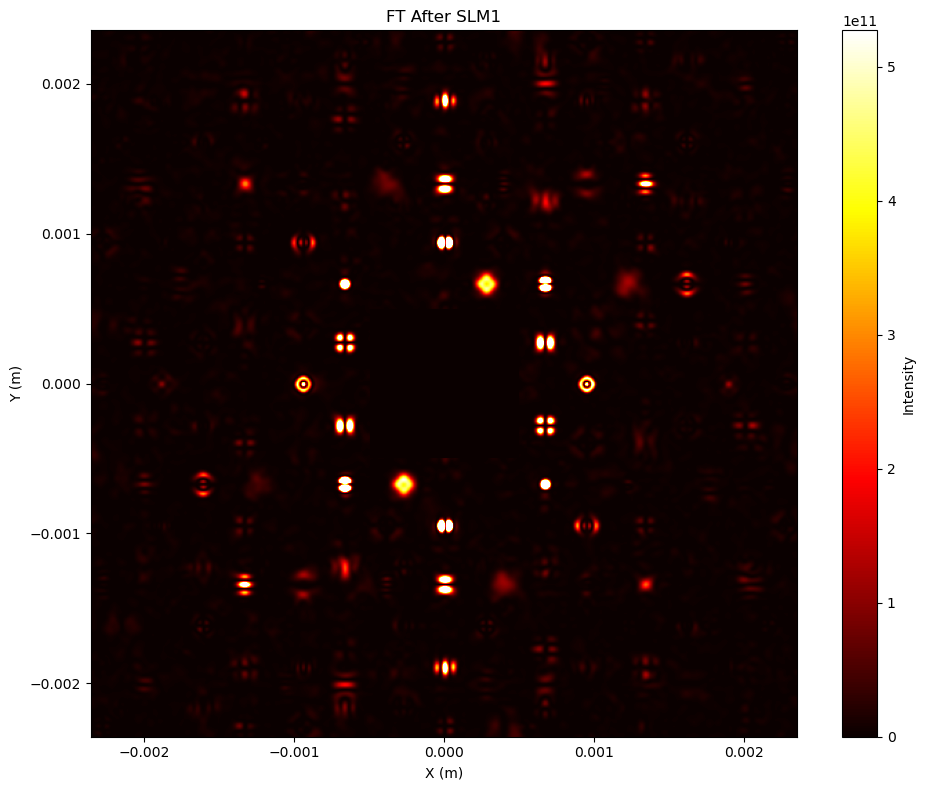

Text(0, 0.5, 'Y (m)')

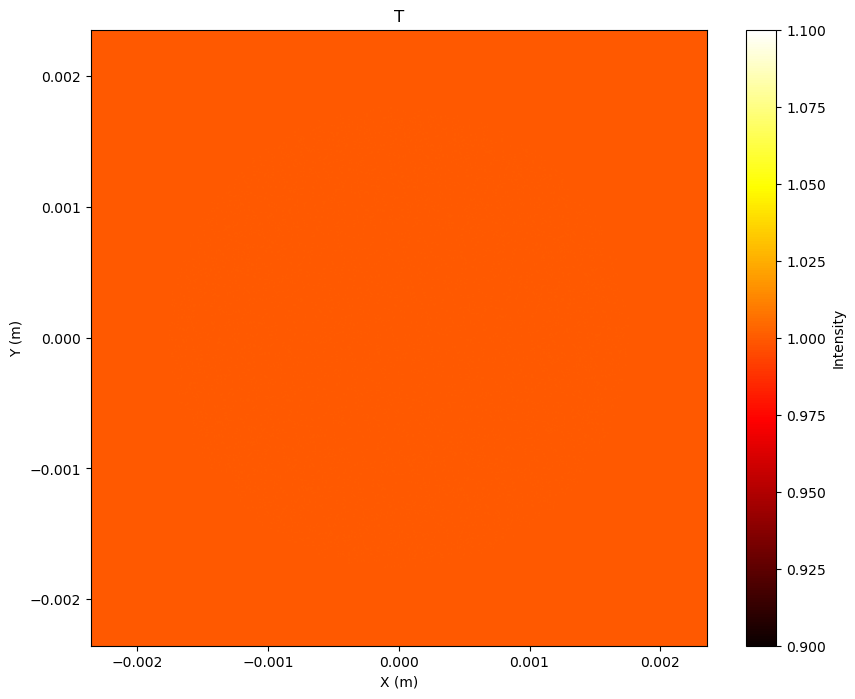

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import genlaguerre, eval_hermite
from scipy.optimize import newton
from scipy.fftpack import fftshift, fft2, ifftshift, ifft2
from matplotlib.colors import Normalize
import math

# 定义 Laguerre-Gaussian 模式
def LG_mode(p, l, X, Y, theta, wz, z):
    r = np.sqrt(X**2 + Y**2)
    theta = np.arctan2(Y, X)
    if z == 0:
        Rz = np.inf
    else:
        Rz = (z**2 + zr**2) / z
    k0 = 2 * np.pi / lamda
    phase = np.exp(-1j * l * theta) * np.exp(1j * (k0 * r**2 / (2 * Rz) - (2*p + np.abs(l) + 1) * np.arctan(z / zr)))
    am = (2 * math.factorial(p) / (np.pi * math.factorial(p + np.abs(l))))**0.5 * \
         (1 / wz) * (np.sqrt(2) * r / wz)**np.abs(l) * np.exp(-(r**2 / wz**2)) * \
         genlaguerre(p, np.abs(l))(2 * r**2 / wz**2)
    return phase * am

def HG_mode(nx, ny, X, Y, wz):
    Hx = eval_hermite(nx, np.sqrt(2) * X / wz)
    Hy = eval_hermite(ny, np.sqrt(2) * Y / wz)
    amplitude = (1 / np.sqrt(2**(nx+ny) * math.factorial(nx) * math.factorial(ny))) * \
                (1 / wz) * \
                np.exp(-(X**2 + Y**2) / wz**2) * \
                Hx * Hy
    phase = np.exp(-1j * (nx + ny + 1) * np.arctan(z / zr))
    return amplitude * phase
    
def LG_mode_conjugate(p, l, X, Y, theta, wz, z):
    return np.conj(LG_mode(p, l, X, Y, theta, wz, z))

# 定义 faeq 函数
def faeq(f_a_ref, a_ref):
    global C
    return j1(f_a_ref) - C * a_ref

# 查找 f_a_ref
def find_f_a_ref(a_ref):
    return newton(faeq, np.ones_like(a_ref) * 1, args=(a_ref,))

# 定义 SLM 的透射率
def slm_transmission(phi, fa):
    return np.exp(1j * (fa * np.sin(phi)))

# 4f 系统的傅里叶变换
def fourier_transform(field):
    return fftshift(fft2(ifftshift(field)))

def inverse_fourier_transform(field):
    return fftshift(ifft2(ifftshift(field)))

# 定义球面波
def spherical_wave(X, Y, z, lamda):
    k = 2 * np.pi / lamda
    R = np.sqrt(X**2 + Y**2 + z**2)
    return np.exp(1j * k * R) / R

# 参数设置
lamda = 0.66e-6
w0 = 500e-6
pix_size = 9.2e-6
size = 512
C = 0.5818
x = np.linspace(-size * pix_size / 2, size * pix_size / 2, size)
y = np.linspace(-size * pix_size / 2, size * pix_size / 2, size)
X, Y = np.meshgrid(x, y)
z = 0
zr = np.pi * w0**2 / lamda
wz = w0 * np.sqrt(1 + (z / zr)**2)

# 引入平移相位因子
a = 5
grating_period = pix_size * a

# 原始二维光栅
phase_shift1 = np.exp(1j * (2 * np.pi * X / grating_period))
phase_shift2 = np.exp(1j * (2 * np.pi * Y / grating_period))

# 旋转二维光栅
theta1 = np.radians(45)  # 45度旋转
theta2 = np.radians(135) # 135度旋转

# 生成旋转后的光栅
X_rot1 = X * np.cos(theta1) - Y * np.sin(theta1)
Y_rot1 = X * np.sin(theta1) + Y * np.cos(theta1)

X_rot2 = X * np.cos(theta2) - Y * np.sin(theta2)
Y_rot2 = X * np.sin(theta2) + Y * np.cos(theta2)

phase_shift3 = np.exp(1j * (2 * np.pi * X_rot1 / grating_period))
phase_shift4 = np.exp(1j * (2 * np.pi * X_rot2 / grating_period))

# 生成 LG 光场并引入平移
LG01_field = LG_mode(1, 0, X, Y, np.arctan2(Y, X), wz, z) * phase_shift1
AMLG01 = np.abs(LG01_field) / np.max(np.abs(LG01_field))
faLG01 = find_f_a_ref(AMLG01)
phiLG01 = np.angle(LG01_field)

HG10_field = HG_mode(1, 0, X, Y, wz) * phase_shift2
AMHG10 = np.abs(HG10_field) / np.max(np.abs(HG10_field))
faHG10 = find_f_a_ref(AMHG10)
phiHG10 = np.angle(HG10_field)

HG01_field = HG_mode(0, 1, X, Y, wz) * phase_shift3
AMHG01 = np.abs(HG01_field) / np.max(np.abs(HG01_field))
faHG01 = find_f_a_ref(AMHG01)
phiHG01 = np.angle(HG01_field)

LG00_field = LG_mode_conjugate(0, 0, X, Y, np.arctan2(Y, X), wz, z) * phase_shift4
AMLG00 = np.abs(LG00_field) / np.max(np.abs(LG00_field))
faLG00 = find_f_a_ref(AMLG00)
phi00 = np.angle(LG00_field)

field = LG01_field + HG10_field + HG01_field + LG00_field
fa = faLG01 + faHG10 + faHG01 + faLG00

# 用户选择入射光类型
incident_type = "LG"  # "plane" 或 "LG"

if incident_type == "plane":
    incident_field = np.ones((size, size))
elif incident_type == "LG":
    incident_field = LG_mode(0, 0, X, Y, np.arctan2(Y, X), wz, z)

field_after_slm1 = incident_field * slm_transmission(np.angle(field), fa)
intensity_after_slm1 = np.abs(field_after_slm1)**2
T= np.abs(slm_transmission(np.angle(field), fa))**2
field_after_slm1_ft = fourier_transform(field_after_slm1)
intensity_after_slm1_ft = np.abs(field_after_slm1_ft)**2

# 计算坐标范围对应的像素索引
x_min, x_max = np.searchsorted(x, [-0.0005, 0.0005])
y_min, y_max = np.searchsorted(y, [-0.0005, 0.0005])

# 设置指定区域的光强为 0
intensity_after_slm1_ft[x_min:x_max, y_min:y_max] = 0

plt.figure(figsize=(10, 8))
plt.title('FT After SLM1')
img = plt.imshow(intensity_after_slm1_ft, cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()], norm=Normalize(vmin=0, vmax=np.max(intensity_after_slm1_ft) / 10))
cbar = plt.colorbar(img)
cbar.set_label('Intensity')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
plt.title('T')
img = plt.imshow(T, cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()])
cbar = plt.colorbar(img)
cbar.set_label('Intensity')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

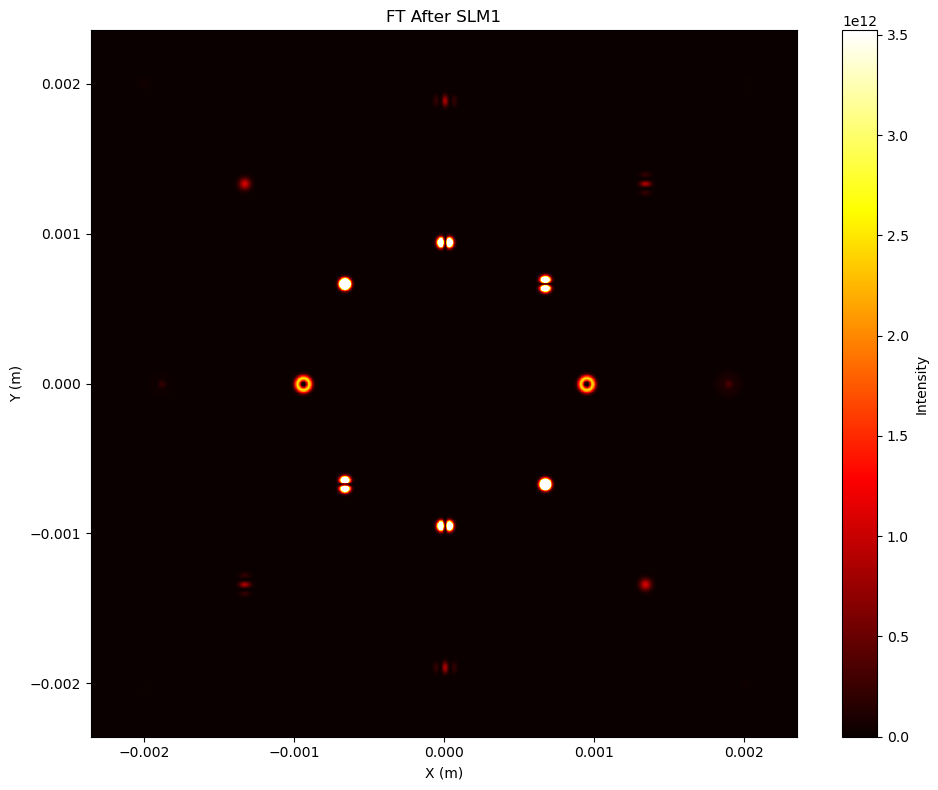

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import genlaguerre, eval_hermite, j1
from scipy.optimize import newton
from scipy.fftpack import fftshift, fft2, ifftshift, ifft2
from matplotlib.colors import Normalize
import math

# 定义 Laguerre-Gaussian 模式
def LG_mode(p, l, X, Y, theta, wz, z):
    r = np.sqrt(X**2 + Y**2)
    theta = np.arctan2(Y, X)
    if z == 0:
        Rz = np.inf
    else:
        Rz = (z**2 + zr**2) / z
    k0 = 2 * np.pi / lamda
    phase = np.exp(-1j * l * theta) * np.exp(1j * (k0 * r**2 / (2 * Rz) - (2*p + np.abs(l) + 1) * np.arctan(z / zr)))
    am = (2 * math.factorial(p) / (np.pi * math.factorial(p + np.abs(l))))**0.5 * \
         (1 / wz) * (np.sqrt(2) * r / wz)**np.abs(l) * np.exp(-(r**2 / wz**2)) * \
         genlaguerre(p, np.abs(l))(2 * r**2 / wz**2)
    return phase * am

def HG_mode(nx, ny, X, Y, wz):
    Hx = eval_hermite(nx, np.sqrt(2) * X / wz)
    Hy = eval_hermite(ny, np.sqrt(2) * Y / wz)
    amplitude = (1 / np.sqrt(2**(nx+ny) * math.factorial(nx) * math.factorial(ny))) * \
                (1 / wz) * \
                np.exp(-(X**2 + Y**2) / wz**2) * \
                Hx * Hy
    phase = np.exp(-1j * (nx + ny + 1) * np.arctan(z / zr))
    return amplitude * phase
    
def LG_mode_conjugate(p, l, X, Y, theta, wz, z):
    return np.conj(LG_mode(p, l, X, Y, theta, wz, z))

# 定义 faeq 函数
def faeq(f_a_ref, a_ref):
    global C
    return j1(f_a_ref) - C * a_ref

# 查找 f_a_ref
def find_f_a_ref(a_ref):
    return newton(faeq, np.ones_like(a_ref) * 1, args=(a_ref,))

# 定义 SLM 的透射率
def slm_transmission(phi, fa):
    return np.exp(1j * (fa * np.sin(phi)))

# 4f 系统的傅里叶变换
def fourier_transform(field):
    return fftshift(fft2(ifftshift(field)))

def inverse_fourier_transform(field):
    return fftshift(ifft2(ifftshift(field)))

# 定义球面波
def spherical_wave(X, Y, z, lamda):
    k = 2 * np.pi / lamda
    R = np.sqrt(X**2 + Y**2 + z**2)
    return np.exp(1j * k * R) / R

# 参数设置
lamda = 0.66e-6
w0 = 500e-6
pix_size = 9.2e-6
size = 512
C = 0.5818
x = np.linspace(-size * pix_size / 2, size * pix_size / 2, size)
y = np.linspace(-size * pix_size / 2, size * pix_size / 2, size)
X, Y = np.meshgrid(x, y)
z = 0
zr = np.pi * w0**2 / lamda
wz = w0 * np.sqrt(1 + (z / zr)**2)

# 引入平移相位因子
a = 5
grating_period = pix_size * a

# 原始二维光栅
phase_shift1 = np.exp(1j * (2 * np.pi * X / grating_period))
phase_shift2 = np.exp(1j * (2 * np.pi * Y / grating_period))

# 旋转二维光栅
theta1 = np.radians(45)  # 45度旋转
theta2 = np.radians(135) # 135度旋转

# 生成旋转后的光栅
X_rot1 = X * np.cos(theta1) - Y * np.sin(theta1)
Y_rot1 = X * np.sin(theta1) + Y * np.cos(theta1)

X_rot2 = X * np.cos(theta2) - Y * np.sin(theta2)
Y_rot2 = X * np.sin(theta2) + Y * np.cos(theta2)

phase_shift3 = np.exp(1j * (2 * np.pi * X_rot1 / grating_period))
phase_shift4 = np.exp(1j * (2 * np.pi * X_rot2 / grating_period))

# 生成 LG 光场并引入平移
LG01_field = LG_mode(1, 0, X, Y, np.arctan2(Y, X), wz, z) * phase_shift1
AMLG01 = np.abs(LG01_field) / np.max(np.abs(LG01_field))
faLG01 = find_f_a_ref(AMLG01)
phiLG01 = np.angle(LG01_field)

HG10_field = HG_mode(1, 0, X, Y, wz) * phase_shift2
AMHG10 = np.abs(HG10_field) / np.max(np.abs(HG10_field))
faHG10 = find_f_a_ref(AMHG10)
phiHG10 = np.angle(HG10_field)

HG01_field = HG_mode(0, 1, X, Y, wz) * phase_shift3
AMHG01 = np.abs(HG01_field) / np.max(np.abs(HG01_field))
faHG01 = find_f_a_ref(AMHG01)
phiHG01 = np.angle(HG01_field)

LG00_field = LG_mode_conjugate(0, 0, X, Y, np.arctan2(Y, X), wz, z) * phase_shift4
AMLG00 = np.abs(LG00_field) / np.max(np.abs(LG00_field))
faLG00 = find_f_a_ref(AMLG00)
phi00 = np.angle(LG00_field)

field = LG01_field + HG10_field + HG01_field + LG00_field
fa = faLG01 + faHG10 + faHG01 + faLG00

# 用户选择入射光类型
incident_type = "LG"  # "plane" 或 "LG"

if incident_type == "plane":
    incident_field = np.ones((size, size))
elif incident_type == "LG":
    incident_field = LG_mode(0, 0, X, Y, np.arctan2(Y, X), wz, z)

field_after_slm1 = incident_field * (slm_transmission(np.angle(LG01_field), faLG01)+slm_transmission(np.angle(HG01_field), faHG01)+slm_transmission(np.angle(HG10_field), faHG10)+slm_transmission(np.angle(LG00_field), faLG00))
intensity_after_slm1 = np.abs(field_after_slm1)**2
T= np.abs(slm_transmission(np.angle(field), fa))**2
field_after_slm1_ft = fourier_transform(field_after_slm1)
intensity_after_slm1_ft = np.abs(field_after_slm1_ft)**2

# 计算坐标范围对应的像素索引
x_min, x_max = np.searchsorted(x, [-0.0005, 0.0005])
y_min, y_max = np.searchsorted(y, [-0.0005, 0.0005])

# 设置指定区域的光强为 0
intensity_after_slm1_ft[x_min:x_max, y_min:y_max] = 0

plt.figure(figsize=(10, 8))
plt.title('FT After SLM1')
img = plt.imshow(intensity_after_slm1_ft, cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()], norm=Normalize(vmin=0, vmax=np.max(intensity_after_slm1_ft) / 5))
cbar = plt.colorbar(img)
cbar.set_label('Intensity')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

plt.tight_layout()
plt.show()


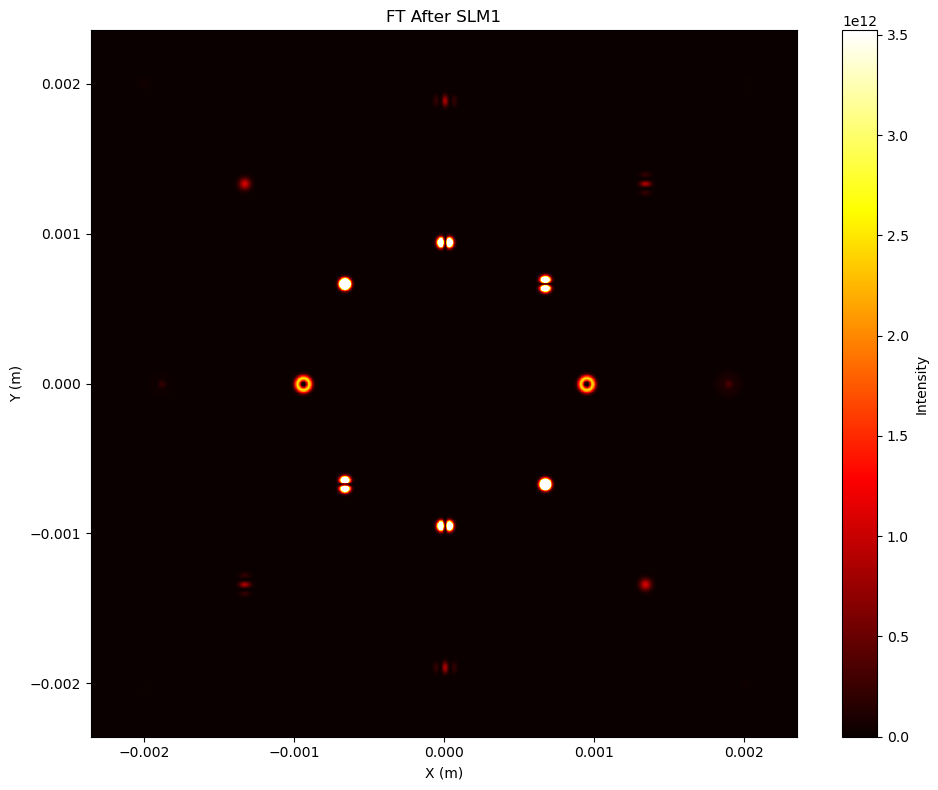

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import genlaguerre, eval_hermite, j1
from scipy.optimize import newton
from scipy.fftpack import fftshift, fft2, ifftshift, ifft2
from matplotlib.colors import Normalize
import math

# 定义 Laguerre-Gaussian 模式
def LG_mode(p, l, X, Y, theta, wz, z):
    r = np.sqrt(X**2 + Y**2)
    theta = np.arctan2(Y, X)
    if z == 0:
        Rz = np.inf
    else:
        Rz = (z**2 + zr**2) / z
    k0 = 2 * np.pi / lamda
    phase = np.exp(-1j * l * theta) * np.exp(1j * (k0 * r**2 / (2 * Rz) - (2*p + np.abs(l) + 1) * np.arctan(z / zr)))
    am = (2 * math.factorial(p) / (np.pi * math.factorial(p + np.abs(l))))**0.5 * \
         (1 / wz) * (np.sqrt(2) * r / wz)**np.abs(l) * np.exp(-(r**2 / wz**2)) * \
         genlaguerre(p, np.abs(l))(2 * r**2 / wz**2)
    return phase * am

def HG_mode(nx, ny, X, Y, wz):
    Hx = eval_hermite(nx, np.sqrt(2) * X / wz)
    Hy = eval_hermite(ny, np.sqrt(2) * Y / wz)
    amplitude = (1 / np.sqrt(2**(nx+ny) * math.factorial(nx) * math.factorial(ny))) * \
                (1 / wz) * \
                np.exp(-(X**2 + Y**2) / wz**2) * \
                Hx * Hy
    phase = np.exp(-1j * (nx + ny + 1) * np.arctan(z / zr))
    return amplitude * phase
    
def LG_mode_conjugate(p, l, X, Y, theta, wz, z):
    return np.conj(LG_mode(p, l, X, Y, theta, wz, z))

# 定义 faeq 函数
def faeq(f_a_ref, a_ref):
    global C
    return j1(f_a_ref) - C * a_ref

# 查找 f_a_ref
def find_f_a_ref(a_ref):
    return newton(faeq, np.ones_like(a_ref) * 1, args=(a_ref,))

# 定义 SLM 的透射率
def slm_transmission(phi, fa):
    return np.exp(1j * (fa * np.sin(phi)))

# 4f 系统的傅里叶变换
def fourier_transform(field):
    return fftshift(fft2(ifftshift(field)))

def inverse_fourier_transform(field):
    return fftshift(ifft2(ifftshift(field)))

# 定义球面波
def spherical_wave(X, Y, z, lamda):
    k = 2 * np.pi / lamda
    R = np.sqrt(X**2 + Y**2 + z**2)
    return np.exp(1j * k * R) / R

# 参数设置
lamda = 0.66e-6
w0 = 500e-6
pix_size = 9.2e-6
size = 512
C = 0.5818
x = np.linspace(-size * pix_size / 2, size * pix_size / 2, size)
y = np.linspace(-size * pix_size / 2, size * pix_size / 2, size)
X, Y = np.meshgrid(x, y)
z = 0
zr = np.pi * w0**2 / lamda
wz = w0 * np.sqrt(1 + (z / zr)**2)

# 引入平移相位因子
a = 5
grating_period = pix_size * a

# 原始二维光栅
ps1 = 2 * np.pi * X / grating_period % (2 * np.pi)
ps2 = 2 * np.pi * Y / grating_period % (2 * np.pi)
phase_shift1 = np.exp(1j * (ps1))
phase_shift2 = np.exp(1j * (ps2))

# 旋转二维光栅
theta1 = np.radians(45)  # 45度旋转
theta2 = np.radians(135) # 135度旋转

# 生成旋转后的光栅
X_rot1 = X * np.cos(theta1) - Y * np.sin(theta1)
Y_rot1 = X * np.sin(theta1) + Y * np.cos(theta1)

X_rot2 = X * np.cos(theta2) - Y * np.sin(theta2)
Y_rot2 = X * np.sin(theta2) + Y * np.cos(theta2)

ps3 = 2 * np.pi * X_rot1 / grating_period % (2 * np.pi)
ps4 = 2 * np.pi * X_rot2 / grating_period % (2 * np.pi)

phase_shift3 = np.exp(1j * (ps3))
phase_shift4 = np.exp(1j * (ps4))

# 生成 LG 光场并引入平移
LG01_field = LG_mode(1, 0, X, Y, np.arctan2(Y, X), wz, z) * phase_shift1
AMLG01 = np.abs(LG01_field) / np.max(np.abs(LG01_field))
faLG01 = find_f_a_ref(AMLG01)
phiLG01 = np.angle(LG01_field)

HG10_field = HG_mode(1, 0, X, Y, wz) * phase_shift2
AMHG10 = np.abs(HG10_field) / np.max(np.abs(HG10_field))
faHG10 = find_f_a_ref(AMHG10)
phiHG10 = np.angle(HG10_field)

HG01_field = HG_mode(0, 1, X, Y, wz) * phase_shift3
AMHG01 = np.abs(HG01_field) / np.max(np.abs(HG01_field))
faHG01 = find_f_a_ref(AMHG01)
phiHG01 = np.angle(HG01_field)

LG00_field = LG_mode_conjugate(0, 0, X, Y, np.arctan2(Y, X), wz, z) * phase_shift4
AMLG00 = np.abs(LG00_field) / np.max(np.abs(LG00_field))
faLG00 = find_f_a_ref(AMLG00)
phi00 = np.angle(LG00_field)

field = LG01_field + HG10_field + HG01_field + LG00_field
fa = faLG01 + faHG10 + faHG01 + faLG00

# 用户选择入射光类型
incident_type = "LG"  # "plane" 或 "LG"

if incident_type == "plane":
    incident_field = np.ones((size, size))
elif incident_type == "LG":
    incident_field = LG_mode(0, 0, X, Y, np.arctan2(Y, X), wz, z)
A= (slm_transmission(np.angle(LG01_field), faLG01)+slm_transmission(np.angle(HG01_field), faHG01)+slm_transmission(np.angle(HG10_field), faHG10)+slm_transmission(np.angle(LG00_field), faLG00))
field_after_slm1 = incident_field * A
intensity_after_slm1 = np.abs(field_after_slm1)**2
T= np.abs(slm_transmission(np.angle(field), fa))**2
field_after_slm1_ft = fourier_transform(field_after_slm1)
intensity_after_slm1_ft = np.abs(field_after_slm1_ft)**2

# 计算坐标范围对应的像素索引
x_min, x_max = np.searchsorted(x, [-0.0005, 0.0005])
y_min, y_max = np.searchsorted(y, [-0.0005, 0.0005])

# 设置指定区域的光强为 0
intensity_after_slm1_ft[x_min:x_max, y_min:y_max] = 0

plt.figure(figsize=(10, 8))
plt.title('FT After SLM1')
img = plt.imshow(intensity_after_slm1_ft, cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()], norm=Normalize(vmin=0, vmax=np.max(intensity_after_slm1_ft) / 5))
cbar = plt.colorbar(img)
cbar.set_label('Intensity')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')

plt.tight_layout()
plt.show()
